C:\Users\virag\AppData\Local\Temp\ipykernel_25264\2076115244.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='H')
c:\Users\virag\miniconda3\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x0000022485E48B80> (for post_execute), with arguments args (),kwargs {}:


AttributeError: 'GeoAxes' object has no attribute 'set_proj_kwargs'

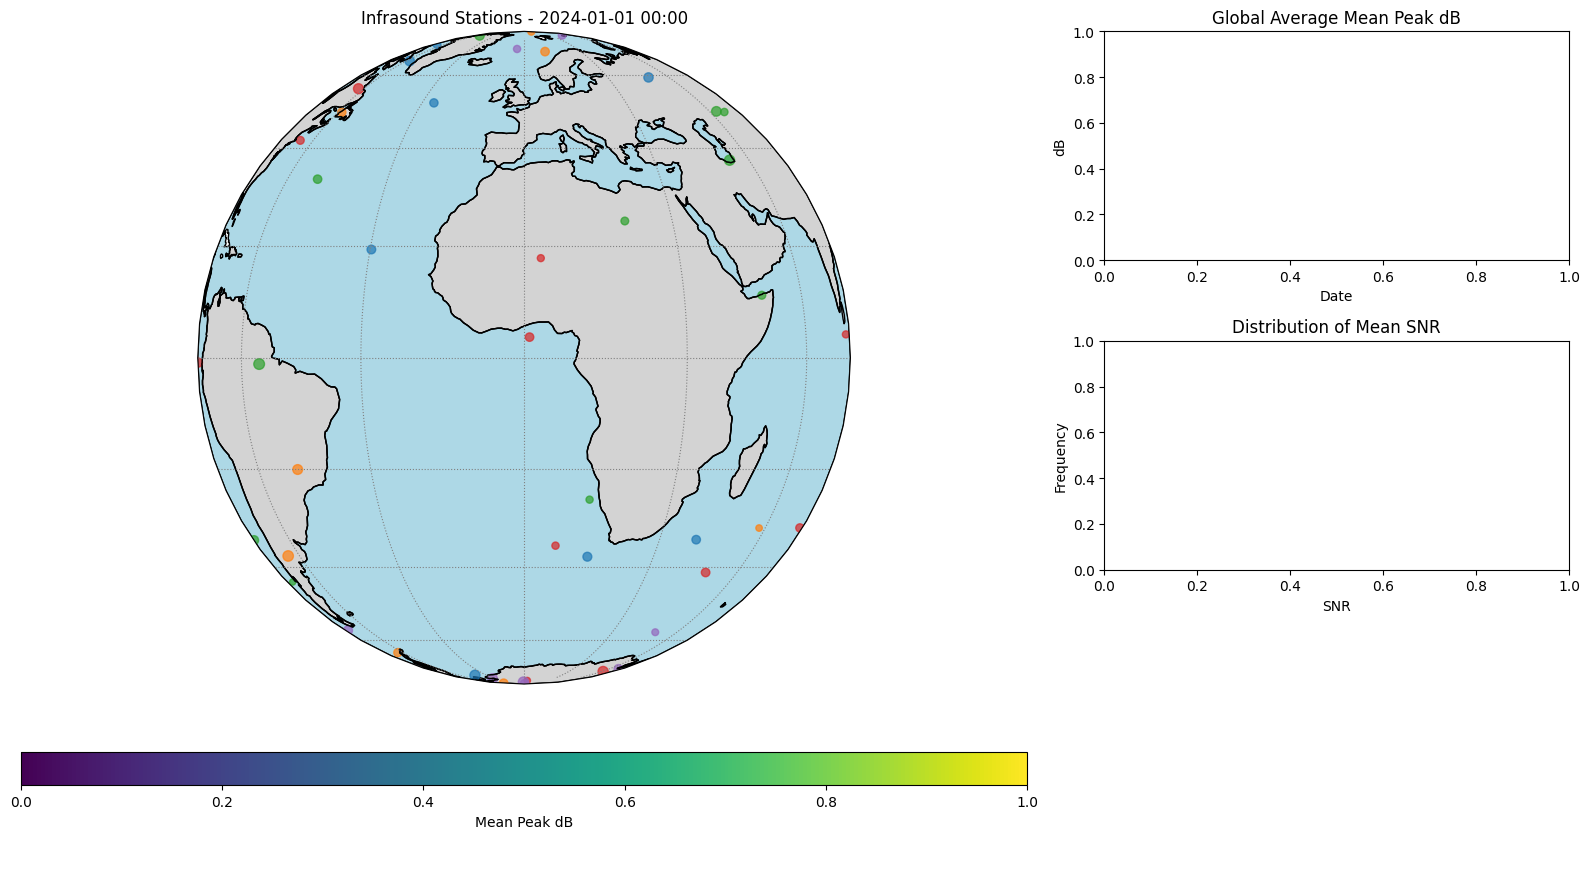

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

# Generate sample data for stations
np.random.seed(42)
n_stations = 100
stations = pd.DataFrame({
    'station_id': [f'ST{i:03d}' for i in range(n_stations)],
    'latitude': np.random.uniform(-90, 90, n_stations),
    'longitude': np.random.uniform(-180, 180, n_stations),
})

# Generate 30 days of hourly data for each station
start_date = pd.Timestamp('2024-01-01')
end_date = start_date + pd.Timedelta(days=30)
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

data = []
for _, station in stations.iterrows():
    for timestamp in date_range:
        data.append({
            'station_id': station['station_id'],
            'timestamp': timestamp,
            'mean_peak_dB': np.random.uniform(60, 100),
            'max_peak_dB': np.random.uniform(80, 120),
            'mean_duration': np.random.uniform(10, 60),
            'mean_background_dB': np.random.uniform(30, 50),
            'max_background_dB': np.random.uniform(40, 70),
            'mean_snr': np.random.uniform(5, 20),
            'max_snr': np.random.uniform(10, 30),
            'max_duration': np.random.uniform(30, 120),
        })

df = pd.DataFrame(data)

# Set up the plot
fig = plt.figure(figsize=(16, 9), dpi=100)
gs = fig.add_gridspec(3, 3)

# Main map
ax_map = fig.add_subplot(gs[:, :2], projection=ccrs.Orthographic(0, 0))
ax_map.set_global()
ax_map.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax_map.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='black')
ax_map.add_feature(cfeature.COASTLINE)
ax_map.gridlines(linestyle=':', color='gray')

# Time series plot
ax_time = fig.add_subplot(gs[0, 2])
ax_time.set_title('Global Average Mean Peak dB')
ax_time.set_xlabel('Date')
ax_time.set_ylabel('dB')

# Histogram
ax_hist = fig.add_subplot(gs[1, 2])
ax_hist.set_title('Distribution of Mean SNR')
ax_hist.set_xlabel('SNR')
ax_hist.set_ylabel('Frequency')

# Text box for statistics
ax_text = fig.add_subplot(gs[2, 2])
ax_text.axis('off')

# Create a custom colormap
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
n_bins = len(colors)
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Function to update the plot for each frame
def update(frame):
    ax_map.clear()
    ax_map.set_global()
    ax_map.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    ax_map.add_feature(cfeature.OCEAN, facecolor='lightblue', edgecolor='black')
    ax_map.add_feature(cfeature.COASTLINE)
    ax_map.gridlines(linestyle=':', color='gray')
    
    current_time = start_date + pd.Timedelta(hours=frame)
    current_data = df[df['timestamp'] == current_time]
    
    scatter = ax_map.scatter(
        stations['longitude'],
        stations['latitude'],
        transform=ccrs.PlateCarree(),
        c=current_data['mean_peak_dB'],
        s=current_data['max_snr'] * 2,
        cmap=cmap,
        alpha=0.7,
    )
    
    ax_map.set_title(f'Infrasound Stations - {current_time.strftime("%Y-%m-%d %H:%M")}')
    
    # Rotate the globe
    ax_map.set_global()
    ax_map.set_proj_kwargs(central_longitude=frame % 360 - 180)
    
    # Update time series
    time_data = df[df['timestamp'] <= current_time].groupby('timestamp')['mean_peak_dB'].mean()
    ax_time.clear()
    ax_time.plot(time_data.index, time_data.values)
    ax_time.set_title('Global Average Mean Peak dB')
    ax_time.set_xlabel('Date')
    ax_time.set_ylabel('dB')
    ax_time.tick_params(axis='x', rotation=45)
    ax_time.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Update histogram
    ax_hist.clear()
    ax_hist.hist(current_data['mean_snr'], bins=20, edgecolor='black')
    ax_hist.set_title('Distribution of Mean SNR')
    ax_hist.set_xlabel('SNR')
    ax_hist.set_ylabel('Frequency')
    
    # Update statistics text
    stats_text = f"Current Time: {current_time.strftime('%Y-%m-%d %H:%M')}\n"
    stats_text += f"Active Stations: {len(current_data)}\n"
    stats_text += f"Avg Mean Peak dB: {current_data['mean_peak_dB'].mean():.2f}\n"
    stats_text += f"Max Peak dB: {current_data['max_peak_dB'].max():.2f}\n"
    stats_text += f"Avg Mean SNR: {current_data['mean_snr'].mean():.2f}\n"
    stats_text += f"Max SNR: {current_data['max_snr'].max():.2f}"
    ax_text.clear()
    ax_text.text(0.05, 0.95, stats_text, verticalalignment='top', fontsize=10)
    
    return scatter,

# Calculate total frames for 30 days of data in 5 minutes
total_hours = 30 * 24
fps = 30
total_frames = 5 * 60 * fps  # 5 minutes * 60 seconds * fps
frame_interval = total_hours / total_frames

# Create the animation
anim = FuncAnimation(fig, update, frames=range(0, total_hours, int(50)), interval=1000/fps, blit=False)

# Add colorbar
cbar = fig.colorbar(ax_map.collections[0], ax=ax_map, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Mean Peak dB')

plt.tight_layout()

# Save the animation (uncomment to save)
anim.save('advanced_infrasound_stations_animation.mp4', writer='ffmpeg', fps=fps)

plt.show()